#Analyze bed files to choose which chromosomes to model

I want to pick some number of chromosomes with both intra and interchromosomal ME/gene dense bodies

In [1]:
ME_body_bed_path = '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/enh-dense_anchors.bed'
Gene_body_bed_path = '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/gene-dense_anchors.bed'
Nuclear_speckles_bed_path = '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/Nuclear_speckle_anchors.bed'

import pandas as pd
from collections import Counter

# Helper function to count features per chromosome from a BED file
def count_features_per_chrom(bed_path):
    chroms = []
    with open(bed_path) as f:
        for line in f:
            if line.strip():
                chrom = line.split()[0]
                chroms.append(chrom)
    return Counter(chroms)

# Count features for each type
enh_counts = count_features_per_chrom(ME_body_bed_path)
gene_counts = count_features_per_chrom(Gene_body_bed_path)
speckle_counts = count_features_per_chrom(Nuclear_speckles_bed_path)

# Get all chromosomes present in any file
all_chroms = set(enh_counts) | set(gene_counts) | set(speckle_counts)

# Build dataframe
rows = []
for chrom in sorted(all_chroms):
    rows.append({
        'chromosome': chrom,
        'enhancer_count': enh_counts.get(chrom, 0),
        'gene_count': gene_counts.get(chrom, 0),
        'speckle_count': speckle_counts.get(chrom, 0)
    })
df = pd.DataFrame(rows)

# Sort by enhancer_count, then gene_count (descending)
df = df.sort_values(['enhancer_count', 'gene_count'], ascending=[False, False]).reset_index(drop=True)
df


,chromosome,enhancer_count,gene_count,speckle_count
0,chr3,65,6,0
1,chr13,45,11,29
2,chr1,45,0,0
3,chr12,38,23,0
4,chr14,38,11,0
5,chr6,35,6,0
6,chr7,28,62,39
7,chr18,27,5,0
8,chr2,25,0,187
9,chr16,15,12,0


In [3]:
# Analyze interchromosomal contacts from loop files
ME_loop_path = '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/ME_loop.txt'
Gene_loop_path = '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/F4v2_loops.txt'

import pandas as pd
from collections import Counter

def analyze_interchromosomal_contacts(loop_path, feature_type):
    """Analyze interchromosomal contacts from a loop file"""
    chrom_pairs = []
    chrom_counts = {}
    
    with open(loop_path) as f:
        for line in f:
            if line.strip():
                parts = line.strip().split('\t')
                chrom1, chrom2 = parts[0], parts[3]
                
                # Only count interchromosomal contacts
                if chrom1 != chrom2:
                    # Create sorted pair to avoid duplicates
                    pair = tuple(sorted([chrom1, chrom2]))
                    chrom_pairs.append(pair)
                    
                    # Count individual chromosomes
                    chrom_counts[chrom1] = chrom_counts.get(chrom1, 0) + 1
                    chrom_counts[chrom2] = chrom_counts.get(chrom2, 0) + 1
    
    # Count pairs
    pair_counts = Counter(chrom_pairs)
    
    # Create pair dataframe
    pair_rows = []
    for (chrom1, chrom2), count in pair_counts.most_common():
        pair_rows.append({
            'chromosome1': chrom1,
            'chromosome2': chrom2,
            f'{feature_type}_contacts': count
        })
    pair_df = pd.DataFrame(pair_rows)
    
    # Create individual chromosome dataframe
    chrom_rows = []
    for chrom, count in sorted(chrom_counts.items(), key=lambda x: x[1], reverse=True):
        chrom_rows.append({
            'chromosome': chrom,
            f'{feature_type}_interchrom_contacts': count
        })
    chrom_df = pd.DataFrame(chrom_rows)
    
    return pair_df, chrom_df

# Analyze both files
me_pairs, me_chroms = analyze_interchromosomal_contacts(ME_loop_path, 'enhancer')
gene_pairs, gene_chroms = analyze_interchromosomal_contacts(Gene_loop_path, 'gene')

print("=== ENHANCER INTERCHROMOSOMAL CONTACTS ===")
print("\nTop 10 Chromosome Pairs:")
print(me_pairs.head(10))
print("\nTop 10 Individual Chromosomes:")
print(me_chroms.head(10))

print("\n\n=== GENE INTERCHROMOSOMAL CONTACTS ===")
print("\nTop 10 Chromosome Pairs:")
print(gene_pairs.head(10))
print("\nTop 10 Individual Chromosomes:")
print(gene_chroms.head(10))

# Combine individual chromosome data
combined_chroms = me_chroms.merge(gene_chroms, on='chromosome', how='outer').fillna(0)
combined_chroms['total_interchrom_contacts'] = combined_chroms['enhancer_interchrom_contacts'] + combined_chroms['gene_interchrom_contacts']
combined_chroms = combined_chroms.sort_values('total_interchrom_contacts', ascending=False).reset_index(drop=True)

print("\n\n=== COMBINED INTERCHROMOSOMAL CONTACTS ===")
print("\nAll Chromosomes (sorted by total contacts):")
print(combined_chroms)

=== ENHANCER INTERCHROMOSOMAL CONTACTS ===

Top 10 Chromosome Pairs:
  chromosome1 chromosome2  enhancer_contacts
0        chr4        chr9                486
1       chr11        chr4                432
2       chr12        chr4                378
3        chr1        chr4                351
4        chr2        chr4                351
5        chr4        chr7                351
6        chr3        chr4                324
7        chr4        chr5                324
8        chr4        chr6                297
9       chr10        chr4                297

Top 10 Individual Chromosomes:
  chromosome  enhancer_interchrom_contacts
0       chr4                          5481
1       chr9                          3816
2      chr11                          3424
3      chr12                          3024
4       chr1                          2821
5       chr2                          2821
6       chr7                          2821
7       chr3                          2616
8       chr5     

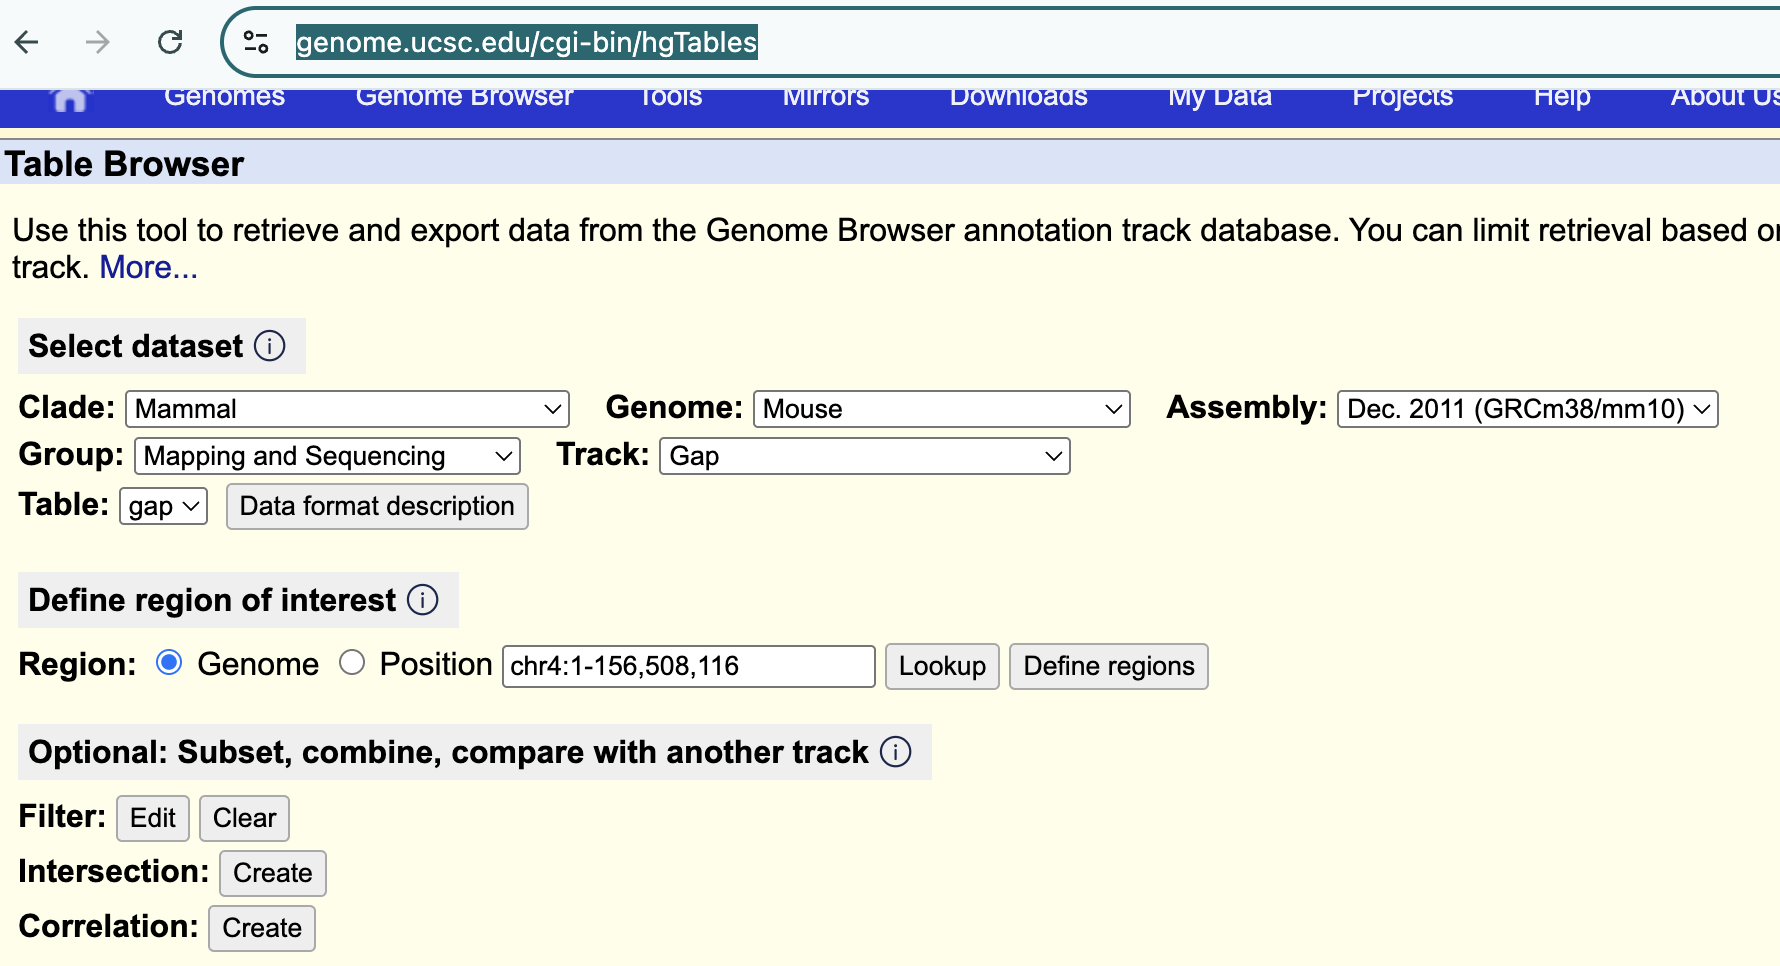

In [5]:
from IPython.display import Image
Image(filename='/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/exp_data_visualization/chromocenters.png',width=800, height=400)

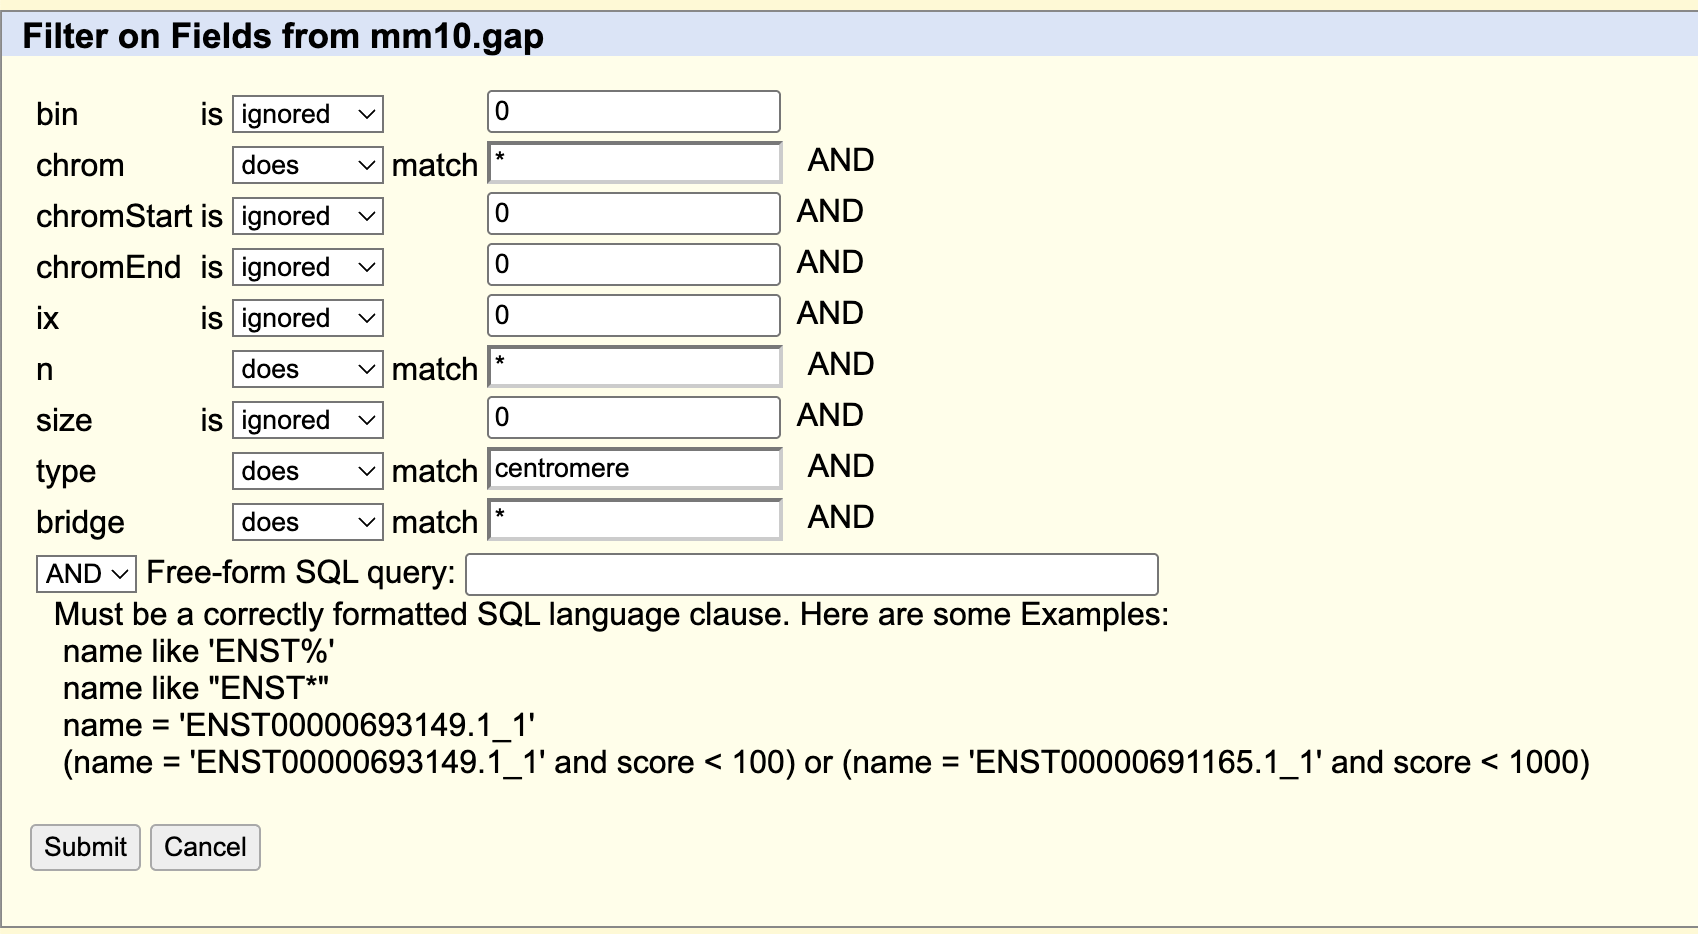

In [6]:
Image(filename='/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/exp_data_visualization/chromocenter_filter.png',width=800, height=400)